In [1]:
%matplotlib widget
from datetime import datetime, timedelta
import glob
from eigsep_corr import io, gain_cal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import hera_qm

In [2]:
DATA_DIR = "/Users/tyler/Work/EIGSEP/data_2024"
files = sorted(glob.glob(f"{DATA_DIR}/2024072*"))  # arrived on the 20th
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)

1155
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'pol23_delay', 'pol45_delay', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)


[  15  361  426  438  443  444  445  446  447  448  449  461  477  485
  489  612  881  925 1023 1117]


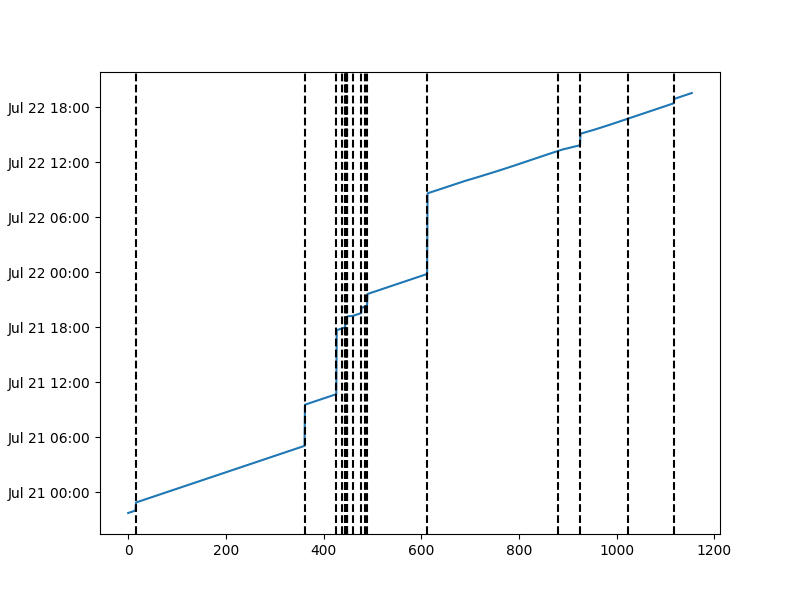

In [3]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    # add one hour to convert from pacific time to local time
    dt = dt + timedelta(hours=1)
    return dt

ftime = np.array([fname2ts(f) for f in files])
timestamps = [ft.timestamp() for ft in ftime]
ix = np.argsort(timestamps)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(timestamps) > np.median(np.diff(timestamps)+1))[:, 0]
print(breaks)

plt.figure(figsize=(8, 6))
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.yticks(rotation=0)
plt.ylabel("Local Time")
plt.show()

In [4]:
observing_windows = {
    "night1": (16, 361),  # sat to sun (all ant on ground)
    "sunday": (361, 426),  # sun morning (all ant on ground)
    "night2": (485, 608),  # sun to mon (box raised)
    "monday_am": (608, 921),  # monday morning/day (rolls + lowering box)
    "monday_pm": (921, 1113),  # raised vivaldi
}

auto = [f"{i}" for i in range(6)]
cross = [f"{i}{i+2}" for i in range(4)] + ["04", "15"]

def load_data(obs_window, pairs=auto+cross):
    mn, mx = observing_windows[obs_window]
    data = {}
    sync_time = None
    acc_cnt = []
    times = []
    for f in files[mn:mx]:
        hdr, dat = io.read_file(f)
        if sync_time is None or hdr["sync_time"] != sync_time:
            print(f, sync_time, hdr["sync_time"])
            sync_time = hdr["sync_time"]
        times.append(hdr["times"])
        acc_cnt.append(hdr["acc_cnt"])
        for k, d in dat.items():
            if k not in pairs:
                continue
            if len(k) == 1:
                d.dtype = io.build_dtype(*hdr["dtype"])
                d = d[..., 0]  # only real part
            else:
                d = d[..., 0] + 1j * d[..., 1]  # complex number
            data[k] = data.get(k, []) + [d]
    for k, v in data.items():
        data[k] = np.concatenate(v, axis=0)
    tmin, tmax = ftime[mn], ftime[mx]
    acc_cnt = np.array(acc_cnt)
    times = np.array(times)
    times = 2 * (times - times[0, 0]) + times[0, 0]  # fixing time calculation bug
    times += 3600  # pacific time to utah time
    return data, hdr, acc_cnt, times, (tmin, tmax)

data, hdr, acc_cnt, times, time_range = load_data("night1", pairs=["0", "1", "2", "3", "02", "13"])
freqs = hdr["freqs"]
print(np.all(np.diff(acc_cnt.ravel()) == 1))  # continuous times

/Users/tyler/Work/EIGSEP/data_2024/20240720_215314.eig None 1721537529.7534614
True


invalid value encountered in divide


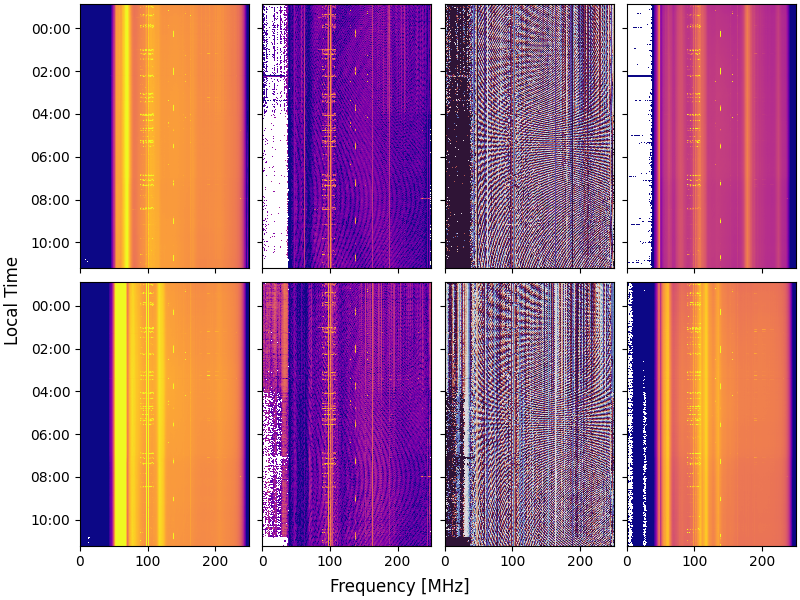

In [5]:
def plot_waterfall(data, times, freqs, title=None, auto_ln=colors.LogNorm(vmin=1e4, vmax=1e6)):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=4, sharex=True, sharey=True, constrained_layout=True)
    cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
    tmin = datetime.fromtimestamp(times[0, 0])
    tmax = datetime.fromtimestamp(times[-1, -1])
    extent = [freqs.min()/1e6, freqs.max()/1e6, tmax, tmin]
    kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    for i, k in enumerate(["02", "13"]):
        autos = {}
        for j in range(2):
            autos[j] = 1/2 * (data[k[j]][:, 0] + data[k[j]][:, 1])
            axs[i, 3*j].imshow(np.abs(autos[j]), norm=auto_ln, **kwargs)
        norm = np.sqrt(autos[0]**2 + autos[1]**2)
        cross = 1/2 * (data[k][:, 0] + data[k][:, 1])
        axs[i, 1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)
        axs[i, 2].imshow(np.angle(cross), aspect="auto", cmap="twilight", extent=extent, interpolation="none", vmin=-np.pi, vmax=np.pi)
    axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    if title:
        plt.suptitle(title)
    plt.show()
    
plot_waterfall(data, times, freqs)

In [6]:
auto = data['0'][10000:, 0]

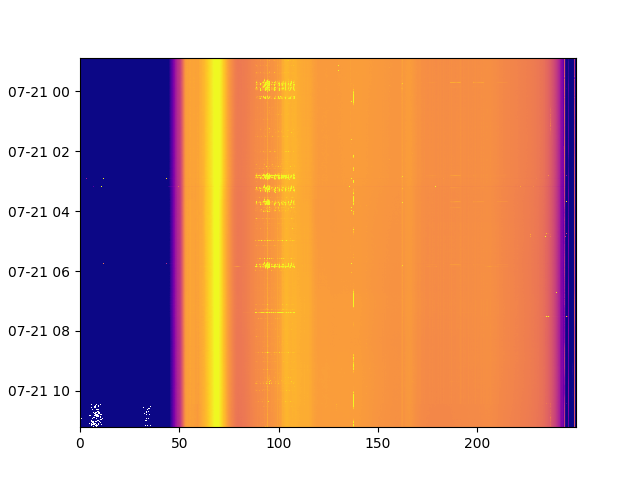

In [7]:
tmin = datetime.fromtimestamp(times[0, 0])
tmax = datetime.fromtimestamp(times[-1, -1])
extent = [freqs.min()/1e6, freqs.max()/1e6, tmax, tmin]
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
plt.figure()
plt.imshow(np.abs(auto), norm=colors.LogNorm(vmin=1e4, vmax=1e6), **kwargs)

In [8]:
wgts = np.ones((auto.shape[0], auto.shape[-1]))
wgts[:, :300] = 0
wgts[:, 900:] = 0
cache = {}

In [9]:
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from astropy.convolution import convolve

In [10]:
footprint = np.ones((5, 5))
footprint[2, 2] = 0
noise_est = auto / np.sqrt(hdr['dfreq'] * hdr['inttime'])
noise_est = median_filter(noise_est, footprint=footprint)

In [11]:
%time med_filtered = median_filter(auto, footprint=footprint)
flags = np.abs(auto - med_filtered) / noise_est > 1e2
%time mean_filtered = convolve(auto, footprint, mask=flags)
post_mean_flags = np.abs(auto - mean_filtered) / noise_est > 5e1
post_mean_flags[:, post_mean_flags.mean(0) > 0.4] = True
post_mean_flags[post_mean_flags.mean(1) > 0.3] = True

CPU times: user 5.58 s, sys: 30.5 ms, total: 5.61 s
Wall time: 5.68 s


divide by zero encountered in divide
invalid value encountered in divide


CPU times: user 922 ms, sys: 69.7 ms, total: 992 ms
Wall time: 990 ms


divide by zero encountered in divide
invalid value encountered in divide


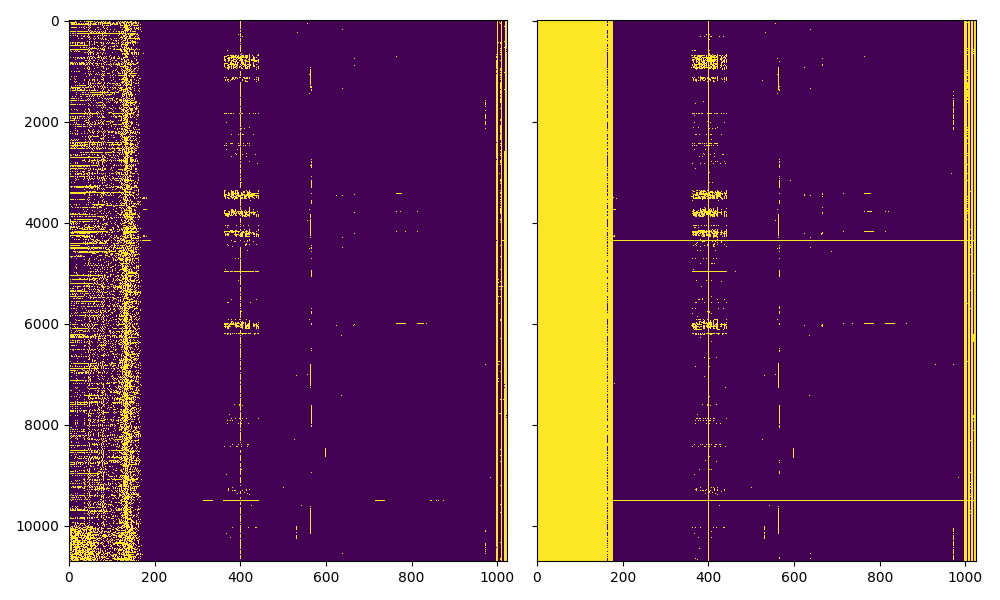

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
axs[0].imshow(flags, aspect='auto', interpolation='none')
axs[1].imshow(post_mean_flags, aspect='auto', interpolation='none')
plt.tight_layout()

In [13]:
s = np.average(auto, weights=(~post_mean_flags).astype(float) + 1e-12, axis=0)
so = np.average(auto, axis=0)

(100000.0, 10000000.0)

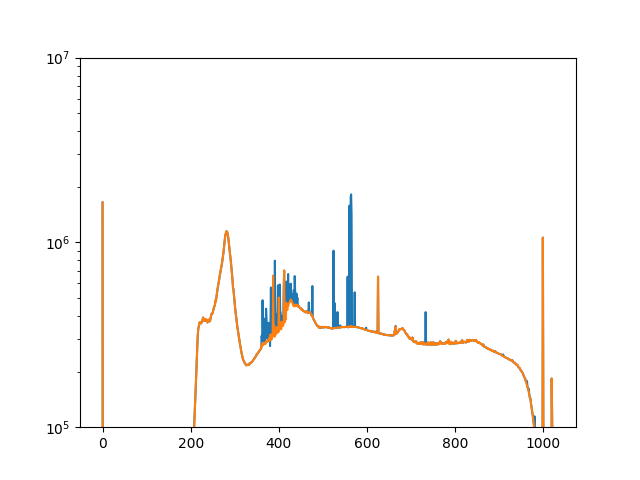

In [14]:
plt.figure()
plt.semilogy(so)
plt.semilogy(s)
plt.ylim([1e5, 1e7])

In [15]:
times.shape

(345, 60)

divide by zero encountered in divide
invalid value encountered in divide


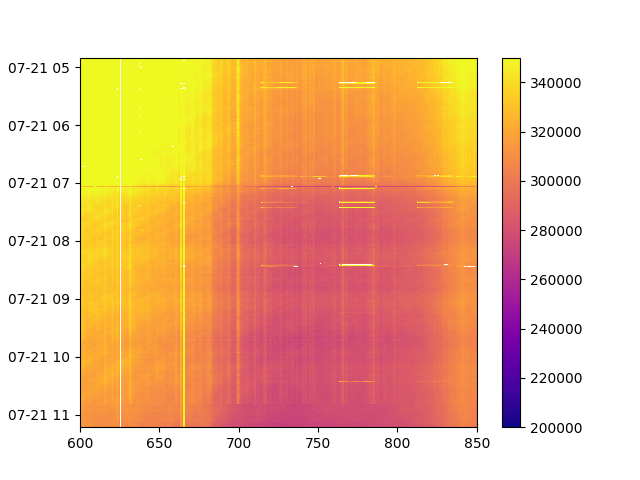

In [16]:
tmin = datetime.fromtimestamp(times.ravel()[10000])
tmax = datetime.fromtimestamp(times[-1, -1])
extent = [0, 1024, tmax, tmin]
kwargs = {"aspect": "auto", "cmap": "plasma", "interpolation": "none", "vmin": 2e5, "vmax": 0.35e6, "extent": extent}
plt.figure()
#plt.imshow(np.abs(auto) / (~post_mean_flags).astype(float), **kwargs)
plt.imshow(np.abs(data['1'][10000:, 0]) / (~post_mean_flags).astype(float), **kwargs)
plt.xlim([600, 850])
plt.colorbar()

In [17]:
%%time
med_zscore = hera_qm.xrfi.detrend_medfilt(auto, Kt=8, Kf=8)
flags = np.abs(med_zscore) > 5
mean_zscore = hera_qm.xrfi.detrend_meanfilt(auto, flags=flags, Kt=8, Kf=8)
all_flags = flags | (mean_zscore > 3) | post_mean_flags
mean_zscore = hera_qm.xrfi.detrend_meanfilt(auto, flags=all_flags, Kt=8, Kf=8)
final_flags = all_flags | (mean_zscore > 3)

invalid value encountered in sqrt


CPU times: user 2min 13s, sys: 1.82 s, total: 2min 15s
Wall time: 2min 19s


In [19]:
med_zscore

(10700, 1024)

In [30]:
med_zscore_copy = np.copy(med_zscore)
med_zscore_copy = np.where(np.isfinite(med_zscore_copy), med_zscore_copy, np.nan)

mean_zscore_copy = np.copy(mean_zscore)
mean_zscore_copy = np.where(np.isfinite(mean_zscore_copy), mean_zscore_copy, np.nan)

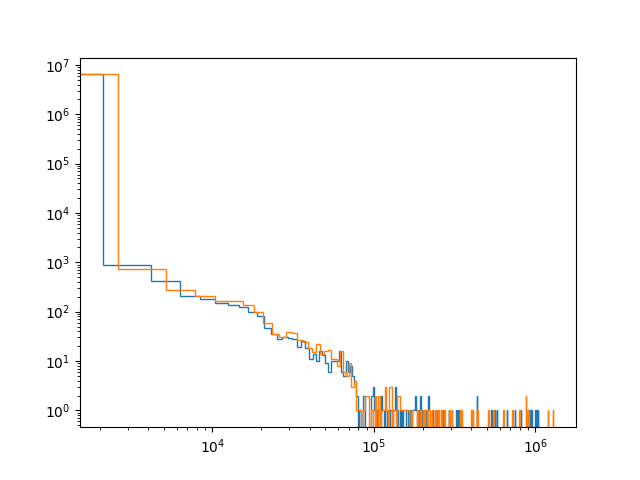

In [31]:
plt.figure()
plt.hist(np.abs(med_zscore_copy[:, 300:900].ravel()), histtype='step', bins=500)
plt.hist(np.abs(mean_zscore_copy[:, 300:900].ravel()), histtype='step', bins=500)
plt.xscale('log')
plt.yscale('log')
plt.show()

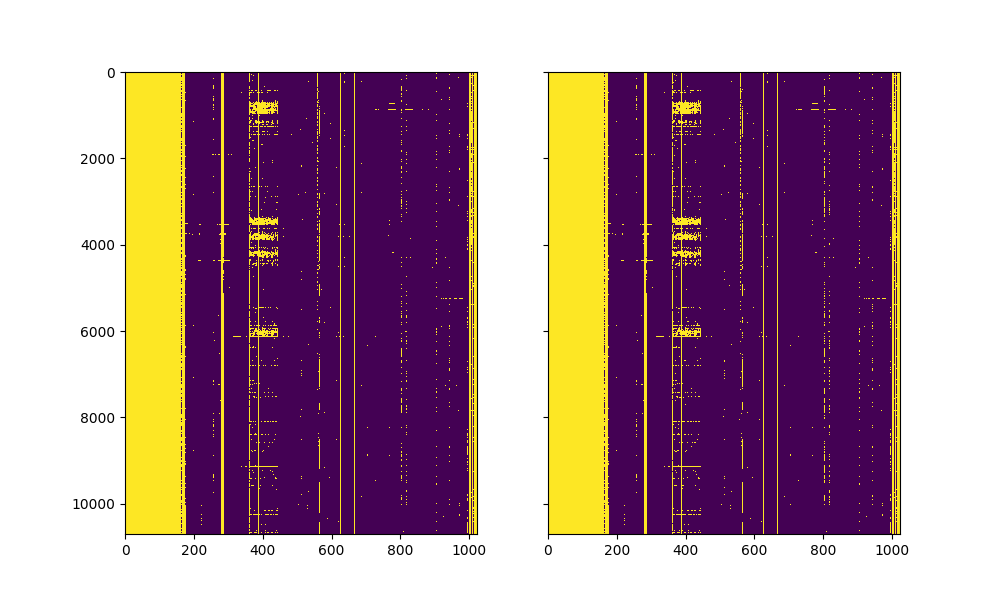

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
axs[0].imshow(all_flags, aspect='auto', interpolation='none')
axs[1].imshow(final_flags, aspect='auto', interpolation='none')
#axs[1].axvline(563)

In [25]:
final_flags[:, final_flags.mean(0) > 0.25] = True
final_flags[final_flags.mean(1) > 0.5] = True

In [26]:
s = np.average(auto, weights=(~final_flags).astype(float) + 1e-12, axis=0)
so = np.average(auto, axis=0)

(100000.0, 10000000.0)

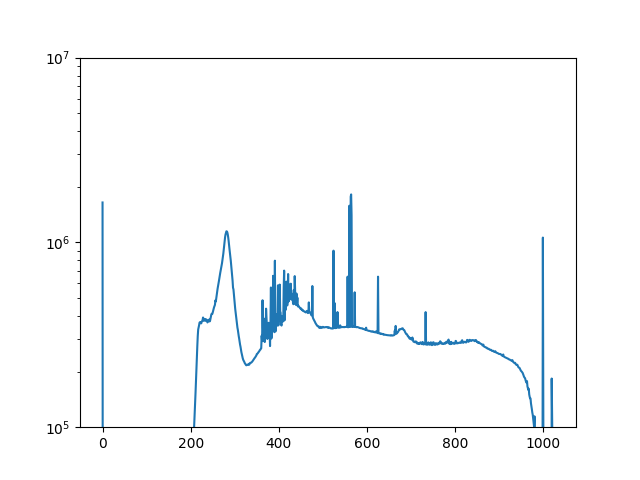

In [29]:
plt.figure()
plt.semilogy(so)
#plt.semilogy(s)
plt.ylim([1e5, 1e7])
#plt.axvline(563)